In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
import matplotlib
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
from itertools import islice

Using TensorFlow backend.


In [2]:
json_file_dir = "G:\\Dev\\trees_gnps"
formula_occurences_path = "G:\\Dev\\fragment_occurences.csv"
saved_intensities_path = "G:\\Dev\\saved_intensities.csv"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"
formula_occurences = {}
num_formula = 0

In [3]:
with open(formula_occurences_path, 'r') as f:
    content = f.readlines()
    num_formula = len(content)
    
print(num_formula)

4616


In [4]:
filenames = [file[:-5] for file in os.listdir(json_file_dir)]

formula = [formula.split(",")[0] for formula in content]
intensities = pd.DataFrame(0.0, index = filenames, columns=formula, dtype=float)

for index, file in enumerate(filenames):
    filepath = os.path.join(json_file_dir, file + ".json")
    with open(filepath, 'r') as f:
        data = json.load(f)

        for fragment in data['fragments']:
            if fragment["molecularFormula"] in formula and "intensity" in fragment:
                intensities.at[file, fragment["molecularFormula"]] = float(fragment["intensity"])
        
        max_intensity = np.amax(intensities.loc[file].values)
        if max_intensity > 0:
            intensities.loc[file].div(np.amax(intensities.loc[file].values)).mul(1000)

In [5]:
intensities.sort_index(inplace=True)
train, validate, test = np.split(intensities.sample(frac=1), [int(.6*len(intensities)), int(.8*len(intensities))])

In [6]:
intensities.to_csv(saved_intensities_path, encoding='utf-8', index=False)

In [7]:
saved_intensities = pd.read_csv(saved_intensities_path, sep=",")
saved_intensities.index = filenames
print(saved_intensities)

                            C9H6          C8H8          C8H6         C9H8  \
CCMSLIB00000001548  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001549  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001550  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001555  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001563  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001565  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001566  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001568  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001569  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001570  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001572  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001574  0.000000e+00  0.000000e+00  2.921284e+02     0.000000   

In [8]:
# Loads a master file containing peak intensities for all molecules.
# Each molecule's spectrum is added as a 1000 element row to a Pandas dataframe
# The dataframe is then converted into a numpy array for use as Keras Input.
# Include the option of adding additonal features to each molecule (mass_shifts variable)
def load_master_file(path, mass_shifts = 0, number_of_bins = 1000):
    mol_all = np.loadtxt(path, dtype="U25") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range(number_of_bins), dtype=float)
    
    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], int(float(row[1]))-1] = float(row[2])
    
    return intensities

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint

    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    return fingerprints

# Load the names of all substructures included in the CDK fingerprint in the correct order
# This is used for boxplots, when performance metrics for individual substructures are calculated.
def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names.
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names.
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line)
    return fingerprint_legend


In [9]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
    
def baseline_model(x_train_spectra, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=x_train_spectra.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

def comparison_model(x_train_formula, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(2000, input_dim=x_train_formula.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(1000,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(500,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

In [10]:
# This function takes as input a trained neural network model and extracts its history variable.
# It then uses it to graph the model's loss and validation loss over the training epochs
# The epochs paramter is used for plotting the x axis.
def plot_loss(fitted_model, epochs):
    # Extract loss values for the training and validation sets.
    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']
    # Create x axis variables.
    epochs_label = epochs
    epochs = range(epochs)

    #Plot both losses.
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss,'r', label='Validation loss')
    plt.title('Training and Validation Loss for ' + str(epochs_label) + ' epochs')
    plt.legend()
    plt.show()

# Takes a trained autoencoder model and input data. Uses the model to predit on the provided data
# It then plots the input data vs. the model's prediction for a specified sample in the data.
def plot_input_output(auto_model, data, sample=0):
    # set font size
    matplotlib.rcParams.update({'font.size': 14})
    # Use model to make predictions for the provided input data.
    decoded_data = auto_model.predict(data)
    # Create plot
    fig, ax = plt.subplots()
    for i, d in enumerate(data[sample]):
        # For each datapoint in the specified sample, plot a vertical line equal to its intensity value.
        if d>0.1:
            ax.plot([i,i],[0, d], color='g')
        # Do the same for the corresponding prediction but using negative values, to create a "mirror" plot
        if decoded_data[sample][i]>0.1:
            ax.plot([i,i],[0,-decoded_data[sample][i]], color='r')
    # Plot invisible line on far end of spectrum so all 1000 mass bins are shown even if absent.
    ax.plot([999,999], [0,0])
    ax.set_xlabel("Mass Bin(Da)")
    ax.set_ylabel("Relative Abundance")
    plt.show()
    
# Takes actual and predicted fingerprint bit sets and plots a representative graph
# Similar to the fragment spectrum plotting.
def plot_fingerprint_output(actual, predicted, sample=0):
    fig, ax = plt.subplots()
    for i, d in enumerate(actual[sample]):
        # For each substructure in fingerprint, plot a vertical line if it is present.
        ax.plot([i,i],[0,d], color='g')
        # DO the same for prediction, using the predicted probability of the susbtructure's presence.
        ax.plot([i,i],[0, -predicted[sample][i]], color = 'r')
    # Plot invisible line on far end of fingerprint.
    ax.plot([307,307], [0,0])
    ax.set_xlabel("Substructure (Index in CDK)")
    ax.set_ylabel("Probability of Presence")
    plt.show()

    
# Takes a actual and predicted fingerprint values and computes the area under the Roc curve for each substructure.
# For each subtructure, also calculates AUC when the actual values are scrambled.
# Return two numpy arrays: one containing AUC metrics for all susbtructures, one containing each permutation's
# AUC scores for each susbtructure.
def compute_auc(bits, true, pred, permutations=500):
    num_permutations = permutations  # Number of permutations to compute AUC scores for. 
    
    # Create structured array to hold statistics for each fingerprint.
    dtype = [('fp_id', int),('nonzeros', int), ('auc', float), ('auc_percent', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    # Create array to hold permutation AUC scores for plotting.
    perm_scores = np.zeros((bits, num_permutations))
    val_start_index = 0
    for fp_id in range(true.shape[1]): # For every substructure      
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[val_start_index:, fp_id]
            fp_pred = pred[val_start_index:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Compute AUC scores for permutations and compare to actual.
            counter = 0         
            for i in range(num_permutations):
                permutation = np.random.permutation(fp_true)
                perm_score = metrics.roc_auc_score(permutation, fp_pred)
                perm_scores[fp_id, i] = perm_score
                # Count how many permutations have a higer AUC score than actual data.
                if perm_score >= score:
                    counter = counter + 1
            # Calculate % of scrambled values with higher AUC score than actual AUC
            percentage = (counter/num_permutations)*100
        # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = fp_id, nonzero_vals, score, percentage
        else:
            mol_stats[fp_id] = (fp_id, nonzero_vals, 0, 100)
        
    # Permutations take a while, print statement to say when finished.
    print("Done")
    return mol_stats, perm_scores


# Given the AUC statistics derived from two separate models, it comapres the two models' performance
# Creates a bar chart comparing substructures above an AUC threshold and draws boxplots for each model's best and worst
# performing substructures.
# Usually compares an experimental model's AUC to a baseline (e.g. the basic fingerprint encoder)
def evaluate(base_stats, base_perm_scores, exp_stats, exp_perm_scores, names):
    # Sort molecules in ascending order of baseline AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((base_stats['auc'] > 0.5))
    abnormal_auc = np.where((base_stats['auc']) < 0.5)
    ordered_base = np.sort(base_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_base[:30]
    sample_fps = np.append(sample_fps, ordered_base[-5:])
    
    # Plot number of substructures with AUC scores above 0.7 and above 0.5 for both data sets
    base_above_07 = len(np.where((base_stats['auc'] >= 0.7))[0])
    exp_above_07 = len(np.where((exp_stats['auc'] >= 0.7))[0])
    base_above_05 = len(np.where((base_stats['auc'] >= 0.5))[0])
    exp_above_05 = len(np.where((exp_stats['auc'] >= 0.5))[0])
    
    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.5
    ax.bar(index, (base_above_05, base_above_07), bar_width, alpha=opacity, color='b', label='Baseline')
    ax.bar(index+bar_width, (exp_above_05, exp_above_07), bar_width, alpha=opacity, color='r', label='Experiment')
    
    ax.set_xlabel('AUC Threshold')
    ax.set_ylabel('Number of Substructures')
    ax.set_title('AUC Score Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Above 0.5', 'Above 0.7'))
    ax.legend()
    
    plt.show()
    
    # Boxplots of sample substructures for both data sets
    boxplots(base_stats, base_perm_scores, sample_fps, names)
    boxplots(exp_stats, exp_perm_scores, sample_fps, names)
    tandem_boxplots(base_stats, base_perm_scores, exp_stats, sample_fps, names)
    
     # Sort molecules in ascending order of experimental AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((exp_stats['auc'] > 0.5))
    abnormal_auc = np.where((exp_stats['auc']) < 0.5)
    ordered_exp = np.sort(exp_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_exp[:30]
    sample_fps = np.append(sample_fps, ordered_exp[-5:])
    
    boxplots(base_stats, base_perm_scores, sample_fps, names)
    boxplots(exp_stats, exp_perm_scores, sample_fps, names)
    tandem_boxplots(base_stats, exp_perm_scores, exp_stats, sample_fps, names)
    


In [11]:
spectra_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"

In [12]:
spectra = load_master_file(spectra_path)
spectra.sort_index(inplace=True)

fingerprints = load_fingerprints_master(fingerprints_path)
fingerprints.sort_index(inplace=True)

In [13]:
epochs = 100
train_spec, validate_spec, test_spec = np.split(spectra.sample(frac=1), [int(.6*len(spectra)), int(.8*len(spectra))])

x_train_spectra = np.log(train_spec.values+1)
x_validate_spectra = np.log(validate_spec.values+1)

x_train_fingerprints = fingerprints[fingerprints.index.isin(train_spec.index)].values
x_validate_fingerprints = fingerprints[fingerprints.index.isin(validate_spec.index)].values

N,M = x_train_spectra.shape
shuffle_order = np.random.permutation(N)

print(x_train_spectra.shape)

(3462, 1000)


In [14]:
b_mod = baseline_model(x_train_spectra, x_train_fingerprints)
history = b_mod.fit(x_train_spectra[shuffle_order,:],x_train_fingerprints[shuffle_order],epochs=epochs,validation_data=(x_validate_spectra,x_validate_fingerprints),verbose=0)

In [15]:
actual = fingerprints[fingerprints.index.isin(test_spec.index)].values
predicted = b_mod.predict(np.log(test_spec.values+1))

In [16]:
base_stats, base_perm_scores = compute_auc(307, actual, predicted)

Done


In [17]:
epochs = 100
x_train_formula = np.log(train.values+1)
x_validate_formula = np.log(validate.values+1)

x_train_fingerprints = fingerprints[fingerprints.index.isin(train.index)].values
x_validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)].values

N,M = x_train_formula.shape
shuffle_order = np.random.permutation(N)

print(x_train_formula.shape)

(3462, 4616)


In [18]:
c_mod = comparison_model(x_train_formula, x_train_fingerprints)
history = c_mod.fit(x_train_formula[shuffle_order,:],x_train_fingerprints[shuffle_order],epochs=epochs,validation_data=(x_validate_formula,x_validate_fingerprints),verbose=0)

In [19]:
actual = fingerprints[fingerprints.index.isin(test.index)].values
predicted = c_mod.predict(np.log(test.values+1))

In [20]:
exp_stats, exp_perm_scores = compute_auc(307, actual, predicted)

Done


In [21]:
fingerprint_names = load_fingerprint_legend()

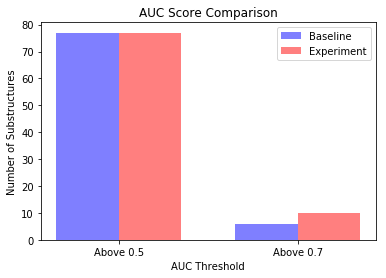

NameError: name 'boxplots' is not defined

In [22]:
evaluate(base_stats, base_perm_scores, exp_stats, exp_perm_scores, fingerprint_names)